# Stage 2.1 — EDA time-series

This notebook builds time-series views over `df_all`, `df_strict`, and `df_sleep` using matplotlib only.

Set SAVE_FIGS=True to export all figures to reports/figures/timeseries (local, gitignored).

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from garmin_analytics.eda import prepare as eda_prepare

SAVE_FIGS: bool = True
FIG_DIR = Path("reports/figures/timeseries")
DPI = 150
FIG_FMT = "png"

add_derived_features = eda_prepare.add_derived_features
build_eda_frames = eda_prepare.build_eda_frames
load_daily_sanitized = eda_prepare.load_daily_sanitized
load_quality = eda_prepare.load_quality

pd.set_option('display.max_columns', 120)

In [73]:
repo_root = Path.cwd() / '..'
daily_sanitized_path = repo_root / 'data/processed/daily_sanitized.parquet'
daily_fallback_path = repo_root / 'data/processed/daily.parquet'
quality_path = repo_root / 'data/processed/daily_quality.parquet'

daily_path = daily_sanitized_path if daily_sanitized_path.exists() else daily_fallback_path
if not daily_path.exists():
    raise FileNotFoundError(f'Daily parquet not found: {daily_path}')
if not quality_path.exists():
    raise FileNotFoundError(f'Quality parquet not found: {quality_path}')

daily_df = load_daily_sanitized(daily_path)
quality_df = load_quality(quality_path)

frames = build_eda_frames(daily_df, quality_df, strict_min_score=4, loose_min_score=3)
df_all = add_derived_features(frames['df_all'])
df_strict = add_derived_features(frames['df_strict'])
df_sleep = add_derived_features(frames['df_sleep'])

# Explicit Stage 2.1 filters (same logic, re-applied for clarity)
for req_col in ['valid_day_strict', 'corrupted_stress_only_day', 'has_sleep']:
    if req_col not in df_all.columns:
        raise KeyError(f'Missing required quality column: {req_col}')

df_strict = df_all[(df_all['valid_day_strict'] == True) & (df_all['corrupted_stress_only_day'] == False)].copy()
df_sleep = df_all[(df_all['has_sleep'] == True) & (df_all['corrupted_stress_only_day'] == False)].copy()

for _df in [df_all, df_strict, df_sleep]:
    _df.sort_values('calendarDate', inplace=True)

print('Daily input:', daily_path)
print('Quality input:', quality_path)

Daily input: /Users/abatrakov/Documents/FUN/wearable-analytics/notebooks/../data/processed/daily_sanitized.parquet
Quality input: /Users/abatrakov/Documents/FUN/wearable-analytics/notebooks/../data/processed/daily_quality.parquet


In [74]:
summary_rows = []
for name, frame in [('df_all', df_all), ('df_strict', df_strict), ('df_sleep', df_sleep)]:
    summary_rows.append({
        'slice': name,
        'rows': len(frame),
        'date_min': frame['calendarDate'].min(),
        'date_max': frame['calendarDate'].max(),
    })

timeseries_summary = pd.DataFrame(summary_rows)
timeseries_summary

,slice,rows,date_min,date_max
0,df_all,580,2023-05-26,2026-02-05
1,df_strict,525,2023-05-26,2026-02-05
2,df_sleep,474,2023-05-27,2026-02-05


In [75]:
def maybe_save(fig, name: str):
    """
    Save a matplotlib figure to FIG_DIR if SAVE_FIGS is True.
    Name should be a short slug (no spaces). The function creates FIG_DIR.
    """
    if not SAVE_FIGS:
        return
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_DIR / f"{name}.{FIG_FMT}", dpi=DPI, bbox_inches="tight")

def plot_ts_with_gaps(ax, df, date_col, y_col, label=None, rolling_days=None):
    """
    Plot y_col vs date_col but break lines across missing dates by reindexing to daily frequency.
    Uses a full daily date_range from min to max, inserts NaN for missing days.
    If rolling_days is provided, also plot rolling mean (on the reindexed daily series).
    Returns the reindexed series.
    """
    if date_col not in df.columns or y_col not in df.columns:
        raise KeyError(f"Missing required columns: {date_col}, {y_col}")

    tmp = df[[date_col, y_col]].copy()
    tmp[date_col] = pd.to_datetime(tmp[date_col], errors='coerce').dt.normalize()
    tmp[y_col] = pd.to_numeric(tmp[y_col], errors='coerce')
    tmp = tmp.dropna(subset=[date_col]).sort_values(date_col)

    if tmp.empty:
        return pd.Series(dtype=float)

    idx = pd.date_range(tmp[date_col].min(), tmp[date_col].max(), freq='D')
    s = tmp.set_index(date_col)[y_col].astype(float).reindex(idx)
    ax.plot(idx, s.values, label=label or y_col)

    if rolling_days:
        min_periods = max(3, rolling_days // 2)
        roll = s.rolling(rolling_days, min_periods=min_periods).mean()
        ax.plot(idx, roll.values, label=f'{rolling_days}-day mean')

    return s

def _find_col(frame: pd.DataFrame, preferred: str, fallback: str | None = None) -> str | None:
    if preferred in frame.columns:
        return preferred
    if fallback is not None and fallback in frame.columns:
        return fallback
    return None

def _plot_line_with_roll(
    frame: pd.DataFrame,
    y_col: str,
    title: str,
    ylabel: str,
    rolling_window: int = 7,
    save_name: str | None = None,
 ) -> None:
    if y_col not in frame.columns or 'calendarDate' not in frame.columns:
        print(f'Skip: missing column {y_col} or calendarDate')
        return
    fig, ax = plt.subplots(figsize=(12, 4))
    series = plot_ts_with_gaps(
        ax,
        frame,
        'calendarDate',
        y_col,
        label=y_col,
        rolling_days=rolling_window,
    )
    if series.empty:
        print(f'Skip: no plottable data for {y_col}')
        plt.close(fig)
        return
    ax.set_title(title)
    ax.set_xlabel('calendarDate')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()
    if save_name is not None:
        maybe_save(fig, save_name)
    plt.show()

## Quality

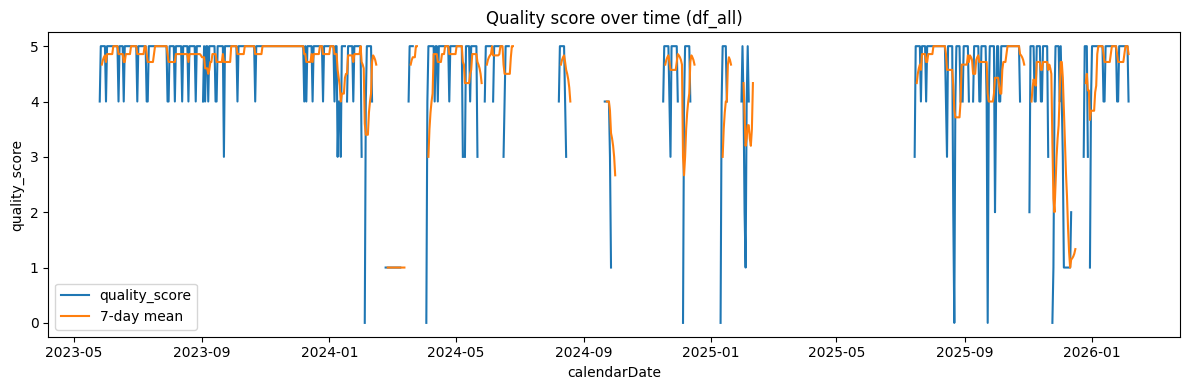

In [76]:
_plot_line_with_roll(df_all, 'quality_score', 'Quality score over time (df_all)', 'quality_score', save_name='quality_score')

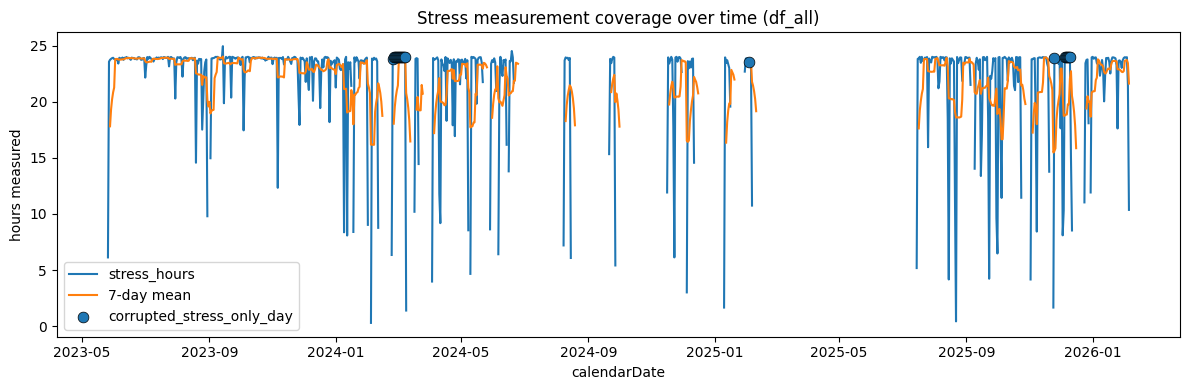

In [77]:
if 'stress_hours' not in df_all.columns:
    print('Skip: missing column stress_hours')
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    stress_s = plot_ts_with_gaps(
        ax,
        df_all,
        'calendarDate',
        'stress_hours',
        label='stress_hours',
        rolling_days=7,
    )

    if 'corrupted_stress_only_day' in df_all.columns and not stress_s.empty:
        corrupted = df_all[df_all['corrupted_stress_only_day'].fillna(False).astype(bool)].copy()
        if not corrupted.empty:
            corrupted['calendarDate'] = pd.to_datetime(corrupted['calendarDate'], errors='coerce').dt.normalize()
            corrupted = corrupted.dropna(subset=['calendarDate'])
            y_corrupted = stress_s.reindex(corrupted['calendarDate'])
            ax.scatter(
                corrupted['calendarDate'],
                y_corrupted.values,
                s=60,
                marker='o',
                edgecolors='k',
                linewidths=0.5,
                zorder=5,
                label='corrupted_stress_only_day',
            )

    ax.set_title('Stress measurement coverage over time (df_all)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('hours measured')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'stress_hours_all')
    plt.show()

## Activity

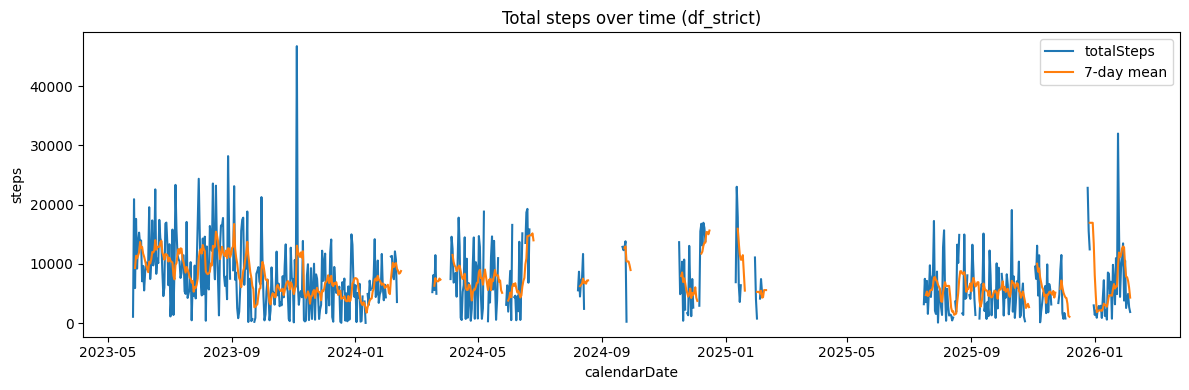

In [78]:
_plot_line_with_roll(df_strict, 'totalSteps', 'Total steps over time (df_strict)', 'steps', save_name='steps_strict')

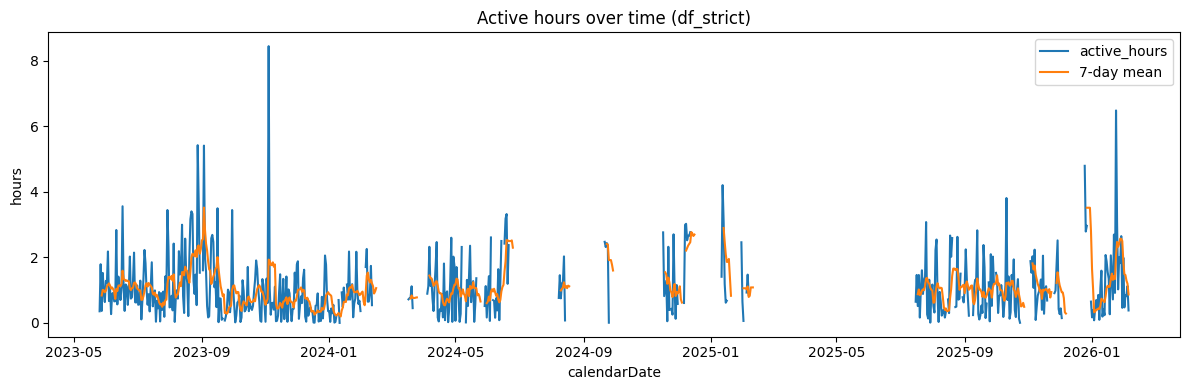

In [79]:
if 'activeSeconds' in df_strict.columns:
    tmp = df_strict[['calendarDate', 'activeSeconds']].copy()
    tmp['active_hours'] = pd.to_numeric(tmp['activeSeconds'], errors='coerce') / 3600.0
    fig, ax = plt.subplots(figsize=(12, 4))
    series = plot_ts_with_gaps(
        ax,
        tmp,
        'calendarDate',
        'active_hours',
        label='active_hours',
        rolling_days=7,
    )
    if series.empty:
        print('Skip: no plottable data for active_hours')
        plt.close(fig)
    else:
        ax.set_title('Active hours over time (df_strict)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('hours')
        ax.legend()
        fig.tight_layout()
        maybe_save(fig, 'active_hours_strict')
        plt.show()
else:
    print('Skip: missing column activeSeconds')

## Stress

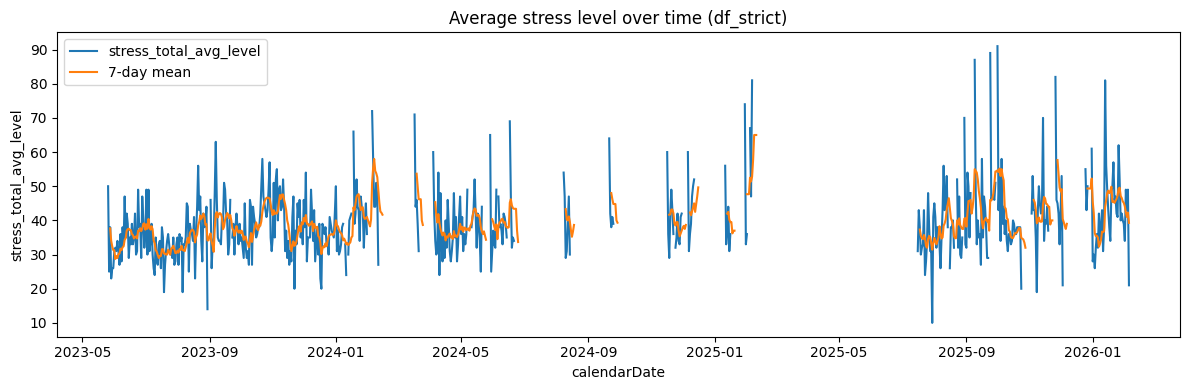

In [80]:
stress_avg_col = _find_col(df_strict, 'stress_total_avg_level', 'allDayStress_TOTAL_averageStressLevel')
if stress_avg_col is None:
    print('Skip: missing stress average level column')
else:
    _plot_line_with_roll(
        df_strict,
        stress_avg_col,
        'Average stress level over time (df_strict)',
        stress_avg_col,
        rolling_window=7,
        save_name='stress_avg_level_strict',
    )

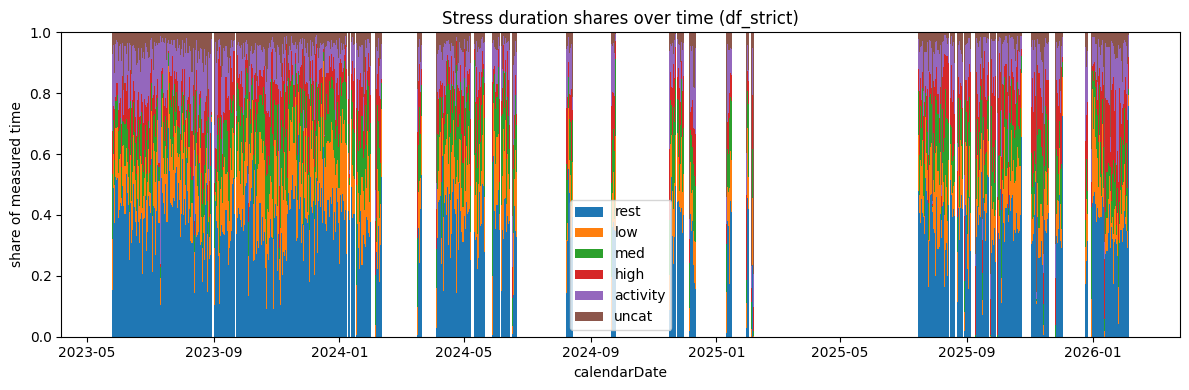

In [81]:
dur_candidates = {
    'rest': _find_col(df_strict, 'stress_total_rest_s', 'allDayStress_TOTAL_restDuration'),
    'low': _find_col(df_strict, 'stress_total_low_s', 'allDayStress_TOTAL_lowDuration'),
    'med': _find_col(df_strict, 'stress_total_med_s', 'allDayStress_TOTAL_mediumDuration'),
    'high': _find_col(df_strict, 'stress_total_high_s', 'allDayStress_TOTAL_highDuration'),
    'activity': _find_col(df_strict, 'stress_total_activity_s', 'allDayStress_TOTAL_activityDuration'),
    'uncat': _find_col(df_strict, 'stress_total_uncat_s', 'allDayStress_TOTAL_uncategorizedDuration'),
}
total_col = _find_col(df_strict, 'stress_total_total_duration_s', 'allDayStress_TOTAL_totalDuration')

if total_col is None or any(v is None for v in dur_candidates.values()):
    print('Skip: missing one or more stress duration columns for share plot')
else:
    stress_df = df_strict[['calendarDate', total_col, *dur_candidates.values()]].copy()
    stress_df['calendarDate'] = pd.to_datetime(stress_df['calendarDate'], errors='coerce').dt.normalize()
    stress_df = stress_df.dropna(subset=['calendarDate'])

    for col in [total_col, *dur_candidates.values()]:
        stress_df[col] = pd.to_numeric(stress_df[col], errors='coerce')

    stress_df = stress_df[stress_df[total_col] > 0].copy()
    if stress_df.empty:
        print('Skip: no rows with positive total stress duration')
    else:
        shares = pd.DataFrame({'calendarDate': stress_df['calendarDate']})
        for label, col in dur_candidates.items():
            shares[label] = stress_df[col] / stress_df[total_col]

        fig, ax = plt.subplots(figsize=(12, 4))
        bottom = np.zeros(len(shares), dtype=float)
        for label in ['rest', 'low', 'med', 'high', 'activity', 'uncat']:
            vals = pd.to_numeric(shares[label], errors='coerce').fillna(0.0).to_numpy()
            ax.bar(
                shares['calendarDate'],
                vals,
                bottom=bottom,
                width=1.0,
                align='center',
                label=label,
            )
            bottom = bottom + vals

        ax.set_ylim(0, 1)
        ax.set_title('Stress duration shares over time (df_strict)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('share of measured time')
        ax.legend()
        fig.tight_layout()
        maybe_save(fig, 'stress_breakdown_shares_strict')
        plt.show()

## Heart

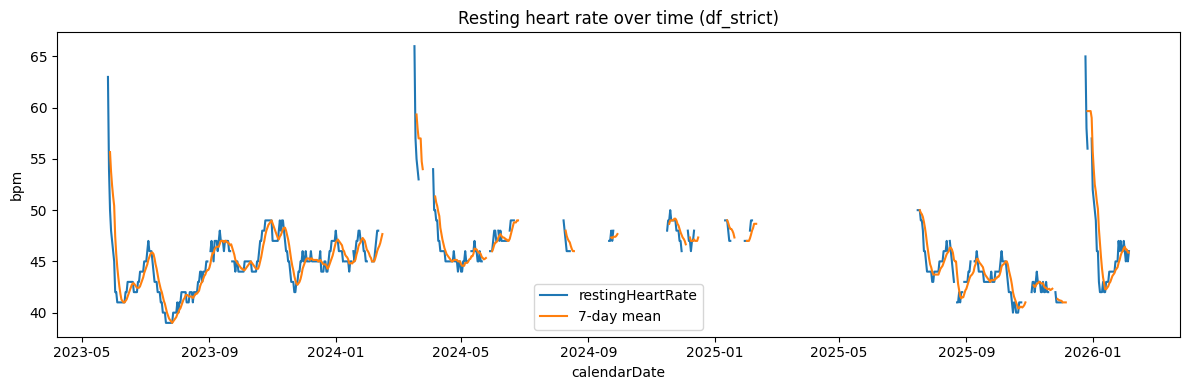

In [82]:
_plot_line_with_roll(df_strict, 'restingHeartRate', 'Resting heart rate over time (df_strict)', 'bpm', save_name='resting_hr_strict')

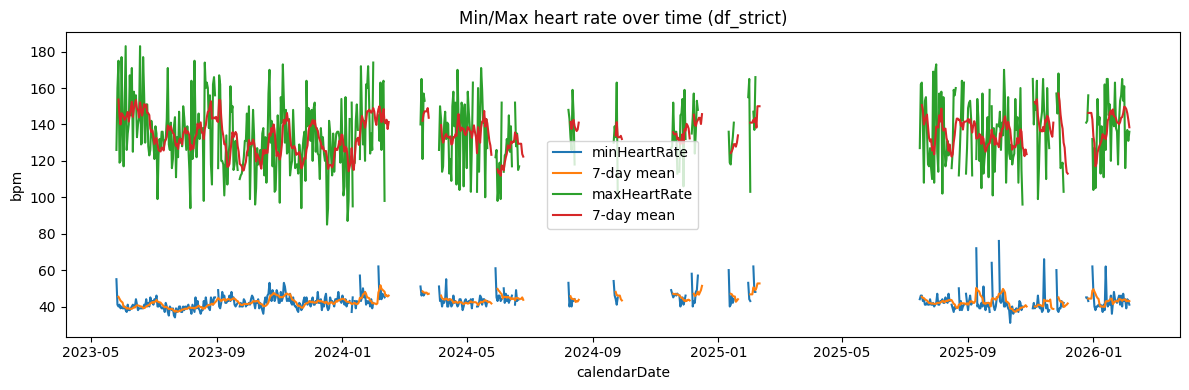

In [83]:
needed = ['minHeartRate', 'maxHeartRate']
if not all(c in df_strict.columns for c in needed):
    print('Skip: missing minHeartRate or maxHeartRate')
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    s_min = plot_ts_with_gaps(
        ax,
        df_strict,
        'calendarDate',
        'minHeartRate',
        label='minHeartRate',
        rolling_days=7,
    )
    s_max = plot_ts_with_gaps(
        ax,
        df_strict,
        'calendarDate',
        'maxHeartRate',
        label='maxHeartRate',
        rolling_days=7,
    )
    if s_min.empty and s_max.empty:
        print('Skip: no plottable data for minHeartRate/maxHeartRate')
        plt.close(fig)
    else:
        ax.set_title('Min/Max heart rate over time (df_strict)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('bpm')
        ax.legend()
        fig.tight_layout()
        maybe_save(fig, 'minmax_hr_strict')
        plt.show()

## BodyBattery

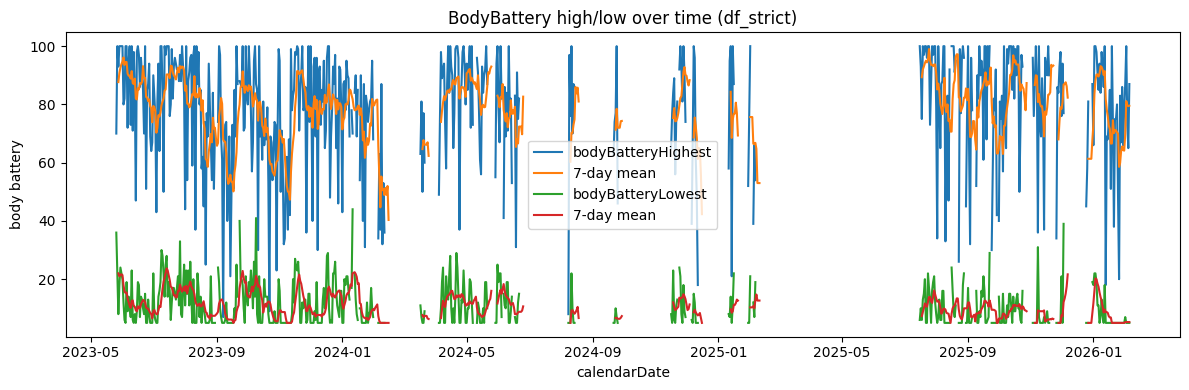

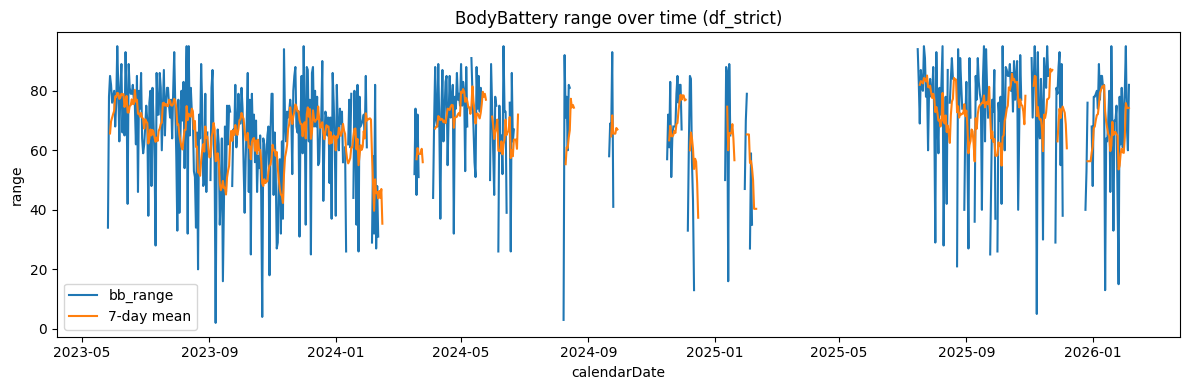

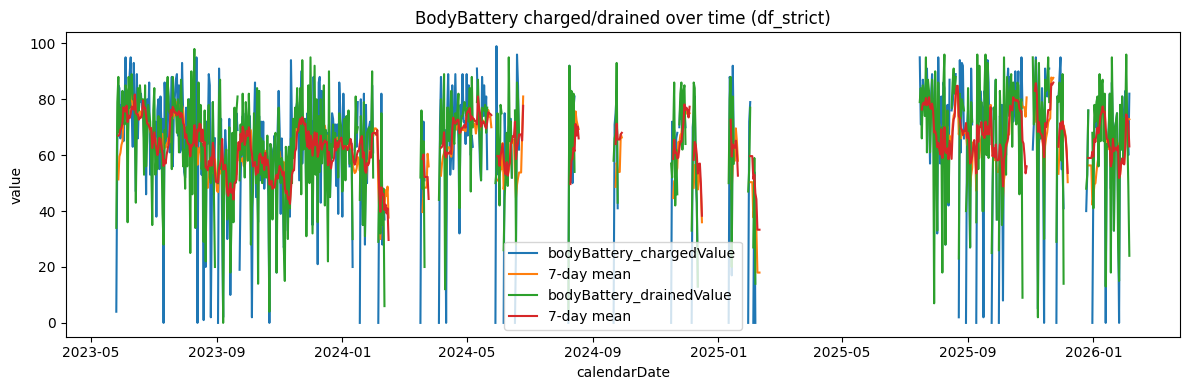

In [84]:
bb_high_col = _find_col(df_strict, 'bodyBatteryHighest', 'bodyBatteryHighest')
bb_low_col = _find_col(df_strict, 'bodyBatteryLowest', 'bodyBatteryLowest')

if bb_high_col is None or bb_low_col is None:
    print('Skip: missing bodyBatteryHighest or bodyBatteryLowest')
else:
    bb_df = df_strict[['calendarDate', bb_high_col, bb_low_col]].copy()
    bb_df[bb_high_col] = pd.to_numeric(bb_df[bb_high_col], errors='coerce')
    bb_df[bb_low_col] = pd.to_numeric(bb_df[bb_low_col], errors='coerce')

    fig, ax = plt.subplots(figsize=(12, 4))
    s_high = plot_ts_with_gaps(
        ax,
        bb_df,
        'calendarDate',
        bb_high_col,
        label='bodyBatteryHighest',
        rolling_days=7,
    )
    s_low = plot_ts_with_gaps(
        ax,
        bb_df,
        'calendarDate',
        bb_low_col,
        label='bodyBatteryLowest',
        rolling_days=7,
    )
    if s_high.empty and s_low.empty:
        print('Skip: no plottable data for bodyBatteryHighest/bodyBatteryLowest')
        plt.close(fig)
    else:
        ax.set_title('BodyBattery high/low over time (df_strict)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('body battery')
        ax.legend()
        fig.tight_layout()
        maybe_save(fig, 'bodybattery_high_low_strict')
        plt.show()

    bb_df['bb_range'] = bb_df[bb_high_col] - bb_df[bb_low_col]
    fig, ax = plt.subplots(figsize=(12, 4))
    s_range = plot_ts_with_gaps(
        ax,
        bb_df,
        'calendarDate',
        'bb_range',
        label='bb_range',
        rolling_days=7,
    )
    if s_range.empty:
        print('Skip: no plottable data for bb_range')
        plt.close(fig)
    else:
        ax.set_title('BodyBattery range over time (df_strict)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('range')
        ax.legend()
        fig.tight_layout()
        maybe_save(fig, 'bb_range_strict')
        plt.show()

charged_col = _find_col(df_strict, 'bodyBattery_chargedValue', 'bodyBatteryChargedValue')
drained_col = _find_col(df_strict, 'bodyBattery_drainedValue', 'bodyBatteryDrainedValue')
if charged_col is None or drained_col is None:
    print('Skip: missing bodyBattery charged/drained columns')
else:
    cd_df = df_strict[['calendarDate', charged_col, drained_col]].copy()
    cd_df[charged_col] = pd.to_numeric(cd_df[charged_col], errors='coerce')
    cd_df[drained_col] = pd.to_numeric(cd_df[drained_col], errors='coerce')

    fig, ax = plt.subplots(figsize=(12, 4))
    s_charged = plot_ts_with_gaps(
        ax,
        cd_df,
        'calendarDate',
        charged_col,
        label='bodyBattery_chargedValue',
        rolling_days=7,
    )
    s_drained = plot_ts_with_gaps(
        ax,
        cd_df,
        'calendarDate',
        drained_col,
        label='bodyBattery_drainedValue',
        rolling_days=7,
    )
    if s_charged.empty and s_drained.empty:
        print('Skip: no plottable data for charged/drained metrics')
        plt.close(fig)
    else:
        ax.set_title('BodyBattery charged/drained over time (df_strict)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('value')
        ax.legend()
        fig.tight_layout()
        maybe_save(fig, 'bodybattery_charged_drained_strict')
        plt.show()

## Sleep

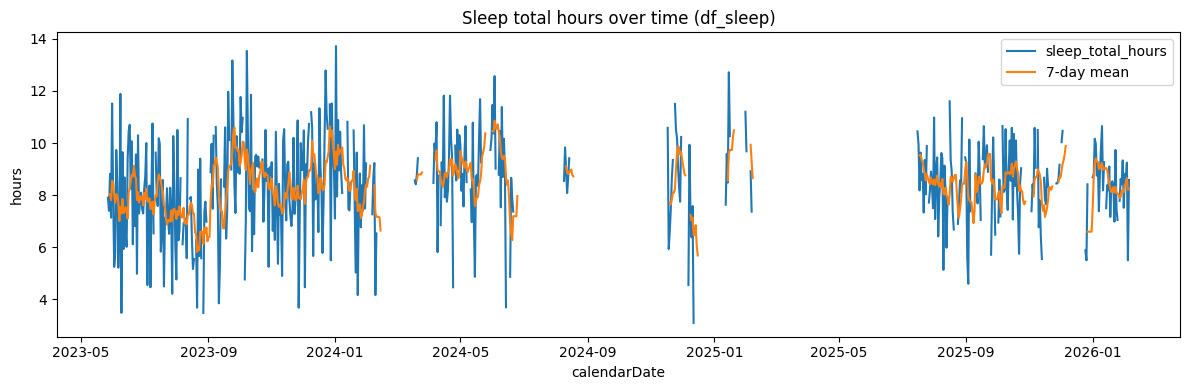

In [85]:
_plot_line_with_roll(df_sleep, 'sleep_total_hours', 'Sleep total hours over time (df_sleep)', 'hours', save_name='sleep_total_hours')

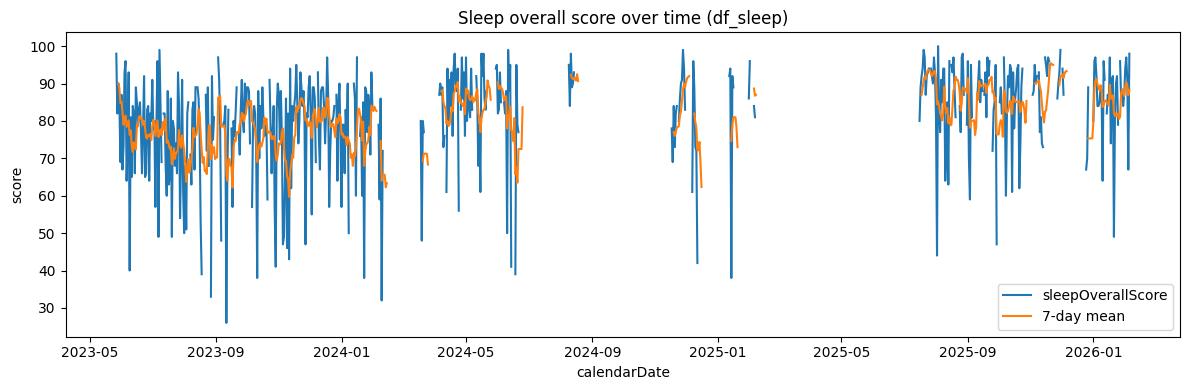

In [86]:
_plot_line_with_roll(df_sleep, 'sleepOverallScore', 'Sleep overall score over time (df_sleep)', 'score', save_name='sleep_overall_score')

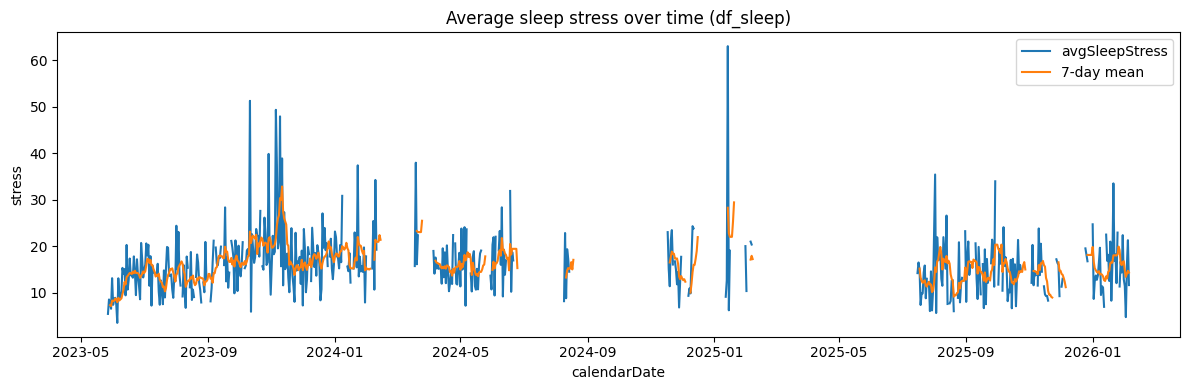

In [87]:
if 'avgSleepStress' in df_sleep.columns:
    _plot_line_with_roll(
        df_sleep,
        'avgSleepStress',
        'Average sleep stress over time (df_sleep)',
        'stress',
        save_name='avg_sleep_stress',
    )
else:
    print('Skip: missing avgSleepStress')

## Optional local save (disabled)

The cell below shows how to save figures locally if needed (kept disabled by default).

In [70]:
# SAVE_FIGURES = False
# if SAVE_FIGURES:
#     out_dir = repo_root / 'reports/figures'
#     out_dir.mkdir(parents=True, exist_ok=True)
#     # plt.savefig(out_dir / 'example.png', dpi=150, bbox_inches='tight')
#     print('Figure output directory:', out_dir)